In [10]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from liquidity.util.utils import compute_returns, get_agg_features

from powerlaw_function.powerlaw_function import Fit

from hurst_exponent.acf import nonlinear_acf
from hurst_exponent.hurst_exponent import standard_hurst, generalized_hurst
from hurst_exponent.util.utils import interpret_hurst, augmented_dickey_fuller

In [11]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# Number of lags for the ACF
ACF_RANGE = 1001

# Window/bin size for computing imbalances
T = 100

# Number of events to use
EVENTS_RANGE = 100000

## Load raw sample data

In [23]:
# Load raw sample data  from CSV
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')


stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2016-R1.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

## 1. Return magnitudes

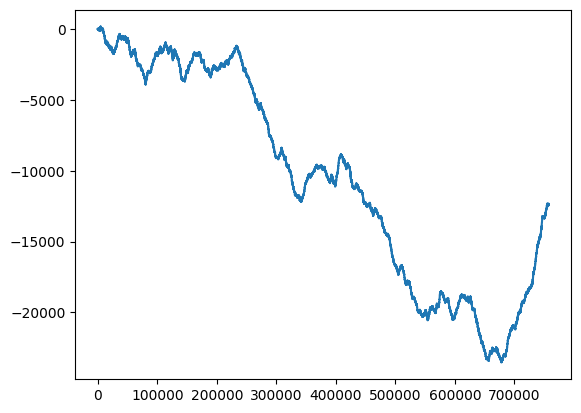

In [24]:
# Return magnitude (volatility)
tsla_returns = compute_returns(tsla_raw_df)['cumsum_returns']
msft_returns = compute_returns(msft_raw_df)['cumsum_returns']
amzn_returns = compute_returns(amzn_raw_df)['cumsum_returns']
nflx_returns = compute_returns(nflx_raw_df)['cumsum_returns']
ebay_returns = compute_returns(ebay_raw_df)['cumsum_returns']
appl_returns = compute_returns(appl_raw_df)['cumsum_returns']

returns_magnitudes = {
  'TSLA': abs(tsla_returns),
  'MSFT': abs(msft_returns),
  'AMZN': abs(amzn_returns),
  'NFLX': abs(nflx_returns),
  'EBAY': abs(ebay_returns),
  'APPL': abs(appl_returns)
}
# Update the dictionary to only keep the first EVENTS_RANGE items
returns_magnitudes = {stock: data.head(EVENTS_RANGE) for stock, data in returns_magnitudes.items()}
tsla_return_magnitudes = tsla_raw_df['trade_sign'].cumsum()
x = list(range(1, len(tsla_return_magnitudes)+1))
plt.plot(x, tsla_return_magnitudes)
plt.grid(False)
plt.show()

### Stationarity Test

In [25]:
# ADF test
for stock, data in returns_magnitudes.items():
    data.head(EVENTS_RANGE)
    augmented_dickey_fuller(data, stock)

TSLA
ADF: -0.75
p-value: 0.83,
N: 99995, 
critical values: {'1%': -3.4304153979486607, '5%': -2.861568904868705, '10%': -2.5667853850501667}
We cannot reject the null hypothesis at a significance level of 0.05.
The time series appears to be non-stationary.


MSFT
ADF: -2.69
p-value: 0.08,
N: 99998, 
critical values: {'1%': -3.4304153959866324, '5%': -2.861568904001529, '10%': -2.5667853845885973}
We cannot reject the null hypothesis at a significance level of 0.05.
The time series appears to be non-stationary.


AMZN
ADF: -2.02
p-value: 0.28,
N: 99998, 
critical values: {'1%': -3.4304153959866324, '5%': -2.861568904001529, '10%': -2.5667853845885973}
We cannot reject the null hypothesis at a significance level of 0.05.
The time series appears to be non-stationary.


NFLX
ADF: -1.78
p-value: 0.39,
N: 99996, 
critical values: {'1%': -3.430415397294638, '5%': -2.86156890457964, '10%': -2.566785384896307}
We cannot reject the null hypothesis at a significance level of 0.05.
The time series

## 2. Orderflow

###  2.1. Signs

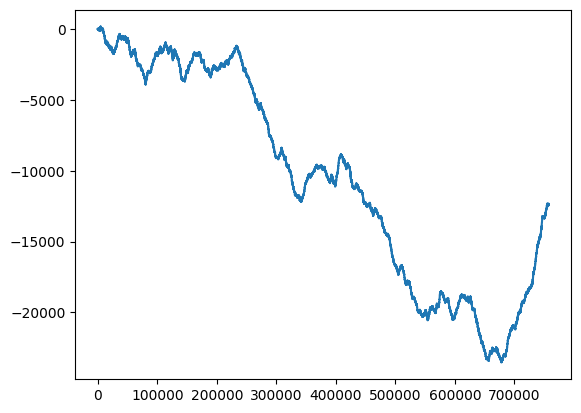

In [26]:
# Signed orderflow
signed_orderflow = {
  'TSLA': tsla_raw_df['trade_sign'].cumsum(),
  'MSFT': msft_raw_df['trade_sign'].cumsum(),
  'AMZN': amzn_raw_df['trade_sign'].cumsum(),
  'NFLX': nflx_raw_df['trade_sign'].cumsum(),
  'EBAY': ebay_raw_df['trade_sign'].cumsum(),
  'APPL': appl_raw_df['trade_sign'].cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
signed_orderflow = {stock: data.head(EVENTS_RANGE) for stock, data in signed_orderflow.items()}
tsla_signed_orderflow = tsla_raw_df['trade_sign'].cumsum()
x = list(range(1, len(tsla_signed_orderflow)+1))
plt.plot(x, tsla_signed_orderflow)
plt.grid(False)
plt.show()

#### Stationarity Test

In [27]:
# ADF test
for stock, data in signed_orderflow.items():
    augmented_dickey_fuller(data, stock)

TSLA
ADF: -1.68
p-value: 0.44,
N: 99938, 
critical values: {'1%': -3.4304154352495755, '5%': -2.861568921354943, '10%': -2.566785393825246}
We cannot reject the null hypothesis at a significance level of 0.05.
The time series appears to be non-stationary.


MSFT
ADF: -1.23
p-value: 0.66,
N: 99963, 
critical values: {'1%': -3.4304154188842877, '5%': -2.861568914121822, '10%': -2.566785389975295}
We cannot reject the null hypothesis at a significance level of 0.05.
The time series appears to be non-stationary.


AMZN
ADF: -1.62
p-value: 0.48,
N: 99933, 
critical values: {'1%': -3.4304154385236156, '5%': -2.8615689228020016, '10%': -2.5667853945954673}
We cannot reject the null hypothesis at a significance level of 0.05.
The time series appears to be non-stationary.


NFLX
ADF: -0.73
p-value: 0.84,
N: 99958, 
critical values: {'1%': -3.4304154221566905, '5%': -2.861568915568157, '10%': -2.566785390745131}
We cannot reject the null hypothesis at a significance level of 0.05.
The time serie

### 1.3. Signed Volume

In [28]:
# Signed Volume
signed_volume = {
  'TSLA': tsla_raw_df['norm_trade_volume'].cumsum() * tsla_raw_df['trade_sign'].cumsum()
  # 'MSFT': msft_raw_df['norm_trade_volume'].cumsum() * msft_raw_df['trade_sign'].cumsum(),
  # 'AMZN': amzn_raw_df['norm_trade_volume'].cumsum() * amzn_raw_df['trade_sign'].cumsum(),
  # 'NFLX': nflx_raw_df['norm_trade_volume'].cumsum() * nflx_raw_df['trade_sign'].cumsum(),
  # 'EBAY': ebay_raw_df['norm_trade_volume'].cumsum() * ebay_raw_df['trade_sign'].cumsum(),
  # 'APPL': appl_raw_df['norm_trade_volume'].cumsum() * appl_raw_df['trade_sign'].cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
signed_volume = {stock: data.head(EVENTS_RANGE) for stock, data in signed_volume.items()}
tsla_signed_volume = tsla_raw_df['norm_trade_volume'].cumsum() * tsla_raw_df['trade_sign'].cumsum()
x = list(range(1, len(tsla_signed_volume)+1))
plt.plot(x, tsla_signed_volume)
plt.grid(False)
plt.show()

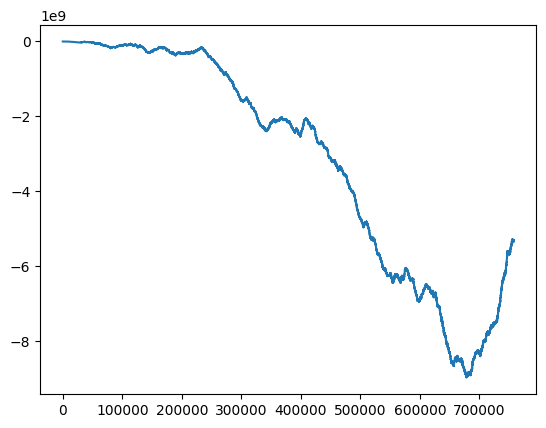

#### Stationarity Test

In [30]:
# ADF test
for stock, data in signed_volume.items():
    augmented_dickey_fuller(data, stock)

TSLA
ADF: -0.63
p-value: 0.86,
N: 99935, 
critical values: {'1%': -3.43041543721396, '5%': -2.8615689222231606, '10%': -2.5667853942873693}
We cannot reject the null hypothesis at a significance level of 0.05.
The time series appears to be non-stationary.




### 1.3. Signed Ordeflow Imbalance

In [31]:
# Aggregate orderflow
tsla_imbalance = get_agg_features(tsla_raw_df, [T])
# msft_imbalance = get_agg_features(tsla_raw_df, [T])
# amzn_imbalance= get_agg_features(tsla_raw_df, [T])
# nflx_imbalance = get_agg_features(tsla_raw_df, [T])
# ebay_imbalance = get_agg_features(tsla_raw_df, [T])
# appl_imbalance = get_agg_features(tsla_raw_df, [T])

# Order Sign imbalance
sign_imbalance = {
  'TSLA': tsla_imbalance['sign_imbalance'].cumsum(),
  # 'MSFT': msft_imbalance['sign_imbalance'].cumsum(),
  # 'AMZN': amzn_imbalance['sign_imbalance'].cumsum(),
  # 'NFLX': nflx_imbalance['sign_imbalance'].cumsum(),
  # 'EBAY': ebay_imbalance['sign_imbalance'].cumsum(),
  # 'APPL': appl_imbalance['sign_imbalance'].cumsum()
}

# Sign Volume Imbalance
volume_imbalance = {
  'TSLA': tsla_imbalance['vol_imbalance'].cumsum(),
  # 'MSFT': msft_imbalance['vol_imbalance'].cumsum(),
  # 'AMZN': amzn_imbalance['vol_imbalance'].cumsum(),
  # 'NFLX': nflx_imbalance['vol_imbalance'].cumsum(),
  # 'EBAY': ebay_imbalance['vol_imbalance'].cumsum(),
  # 'APPL': appl_imbalance['vol_imbalance'].cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
sign_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in sign_imbalance.items()}
volume_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in volume_imbalance.items()}

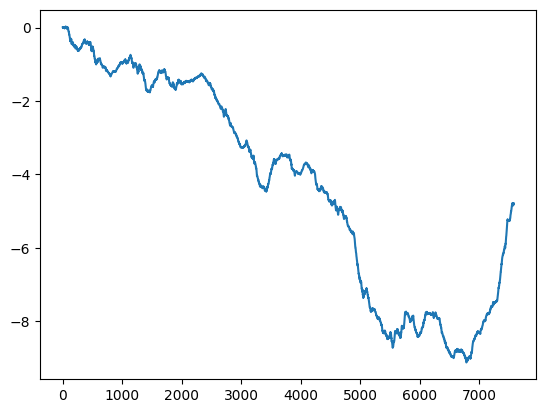

In [32]:
tsla_sign_imbalance = tsla_imbalance['sign_imbalance'].cumsum()
x = list(range(1, len(tsla_sign_imbalance)+1))
plt.plot(x, tsla_sign_imbalance)
plt.grid(False)
plt.show()

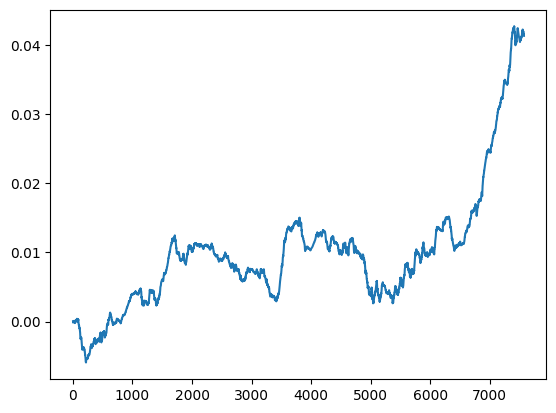

In [33]:
tsla_volume_imbalance = tsla_imbalance['vol_imbalance'].cumsum()
x = list(range(1, len(tsla_volume_imbalance)+1))
plt.plot(x, tsla_volume_imbalance)
plt.grid(False)
plt.show()

#### Stationarity Test

In [34]:
# ADF test
for stock, data in sign_imbalance.items():
    augmented_dickey_fuller(data, stock)

TSLA
ADF: -1.56
p-value: 0.50,
N: 7551, 
critical values: {'1%': -3.43121631233081, '5%': -2.8619228448447456, '10%': -2.566973783870177}
We cannot reject the null hypothesis at a significance level of 0.05.
The time series appears to be non-stationary.




In [35]:
# ADF test
for stock, data in volume_imbalance.items():
    augmented_dickey_fuller(data, stock)

TSLA
ADF: 1.63
p-value: 1.00,
N: 7555, 
critical values: {'1%': -3.4312158535051616, '5%': -2.861922642107883, '10%': -2.566973675950596}
We cannot reject the null hypothesis at a significance level of 0.05.
The time series appears to be non-stationary.




## 3. Autocorrelation Functions


In [36]:
# Compute ACF from raw series (e.g., not the cumsum or cumprod, but bare return_magnitudes)
acf_data_dir = os.path.join(root_dir, 'data', 'generated', 'mo_data')
orderflow_acfs_filename = f"{acf_data_dir}/mo_orderflow_acfs.pkl"

if not os.path.exists(orderflow_acfs_filename):

    # Compute ACF from raw series (e.g., not the cumsum or cumprod, but raw return_magnitudes)
    from pathos.multiprocessing import ProcessingPool
    def compute_nonlinear_acf_for_dict(data_dict, acf_range, method='spearman'):
        result = {}
        for stock, series in data_dict.items():
            result[stock] = nonlinear_acf(series, acf_range, method=method)
        return result

    def compute_for_dict_name(dict_name_data_dict, acf_range, method='spearman'):
        dict_name, data_dict = dict_name_data_dict
        return dict_name, compute_nonlinear_acf_for_dict(data_dict, acf_range, method=method)

    all_dicts_names = ["returns_magnitudes", "signed_orderflow", "signed_volume", "sign_imbalance", "volume_imbalance"]
    all_dicts = [returns_magnitudes, signed_orderflow, signed_volume, sign_imbalance, volume_imbalance]

    pool = ProcessingPool(processes=4)  # adjust the number of processes as needed
    all_results = dict(pool.map(compute_for_dict_name, zip(all_dicts_names, all_dicts), [ACF_RANGE]*len(all_dicts_names), ['spearman']*len(all_dicts_names)))
    pool.close()
    pool.join()

    # Save all ACF results for lazy loading
    pickle.dump(all_results, open(orderflow_acfs_filename, "wb"))

# Load data
all_acfs_loaded = pickle.load(open(orderflow_acfs_filename, "rb"))
print(all_acfs_loaded.keys())

dict_keys(['returns_magnitudes', 'signed_orderflow', 'signed_volume', 'sign_imbalance', 'volume_imbalance'])


In [37]:
tsa_acf_return_magnitudes = all_acfs_loaded['returns_magnitudes']['TSLA']

In [38]:
def plot_acf(stock_name, random_variate, nonlinear_acf):
    plt.figure(figsize=(10, 4))

    # Original scale
    plt.subplot(1, 2, 1)
    plt.plot(range(ACF_RANGE), nonlinear_acf, label='Nonlinear', color='blue')
    plt.grid(False)
    plt.legend(frameon=False)

    # log scale
    plt.subplot(1, 2, 2)
    plt.plot(range(ACF_RANGE), nonlinear_acf, label='Nonlinear', color='green')
    plt.grid(False)
    plt.loglog()
    plt.legend(frameon=False)
    plt.suptitle(f'Nonlinear ACF across lags for {stock_name} {random_variate}')

    plt.show()

In [ ]:
# Plot ACF for each random variable and each stock
for random_variate, stocks_data in all_acfs_loaded.items():
    for stockname in stocks_data.keys():
        plot_acf(stockname, random_variate, stocks_data[stockname])

## 4. The Long Memory of Orderflow

### 4.1. Estimate ACF scaling parameter
Infer an autocorrelation function from a finite return sample, and then we can fit a power-law to the inferred ACF to infer whether the process has long memory.

In [40]:
# Load the pre-computed ACFs
# 1. Construct values for x- and y-axis of our ACF
def construct_xy(sample: pd.Series) -> pd.DataFrame:
    y_values = list(sample)
    x_values = list(range(1, len(y_values) + 1))

    xy_df = pd.DataFrame({
        'x_values': x_values,
        'y_values': y_values
    })

    return xy_df


def fit_powerlaw_for_stock(stock_data_tuple):
    dict_name, stock, data = stock_data_tuple
    acf_values = construct_xy(data)

    fit = Fit(acf_values)  # Constructed DataFrame passed here
    fit_dict = fit.powerlaw.to_dictionary()

    if fit_dict.get("function_name") == "powerlaw":
        alpha = fit.powerlaw.params.alpha  # Extract 'alpha'
        fit_dict.update({
            'alpha': alpha,
            'stock': stock,
            'dict_name': dict_name
        })
        return fit_dict, fit  # Return both dictionary and fit object
    return None, None

In [41]:
# Choose a specific variable, for example 'returns_magnitudes'
fit_results_list = []
fit_objects = {}  # Dictionary to store fit objects

# Choose a specific variable, for example 'returns_magnitudes'
dict_name = 'signed_orderflow'

for stock, data in all_acfs_loaded[dict_name].items():
    fit_dict, fit_obj = fit_powerlaw_for_stock((dict_name, stock, data))
    if fit_dict:
        fit_results_list.append(fit_dict)
        fit_objects[(stock, dict_name)] = fit_obj  # Store the fit object

acf_fit_results = pd.DataFrame(fit_results_list)
acf_fit_results

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,alpha,stock,dict_name
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.9931158...",387,388.0,0.130293,-7948.797713,9.343122,0.729433,-0.659105,TSLA,signed_orderflow
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0948828...",7,8.0,0.108652,-12909.788902,9.496436,0.913372,-0.376235,MSFT,signed_orderflow
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1436890...",7,8.0,0.116700,-11510.500750,6.624995,0.882493,-0.316003,AMZN,signed_orderflow
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0601534...",22,23.0,0.070480,-13265.038631,6.025689,0.887178,-0.236579,NFLX,signed_orderflow
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.2102773...",5,6.0,0.171687,-11645.905825,19.962886,0.901505,-0.501688,EBAY,signed_orderflow
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1014585...",9,10.0,0.115927,-12306.141192,7.981700,0.889659,-0.304548,APPL,signed_orderflow


In [42]:
fit_objects.keys()

dict_keys([('TSLA', 'signed_orderflow'), ('MSFT', 'signed_orderflow'), ('AMZN', 'signed_orderflow'), ('NFLX', 'signed_orderflow'), ('EBAY', 'signed_orderflow'), ('APPL', 'signed_orderflow')])

In [43]:
# Retrieve the fit object for 'STOCK' using the 'random_variable' dictionary:
# tsla_acf_fit = fit_objects[('APPL', 'returns_magnitudes')]
# tsla_acf_fit.powerlaw.plot_fit()

In [44]:
# Average value for alpha of 'random_variable' accross 'STOCKS'
avg_alpha = acf_fit_results['alpha'].mean()
print(f"Average Alpha: {avg_alpha}")

Average Alpha: -0.3990262266391975


### 4.2. Estimate Hurst exponent

The Hurst Exponent, denoted by $H$, is a statistical measure of a time series which can be used to determine the long memory nature of the series. Its value can range between 0 and 1:

In [45]:
def compute_hurst_for_stock(stock_data_tuple, method='standard'):
    dict_name, stock, data = stock_data_tuple

    if method == 'standard':
        hurst_val, fit = standard_hurst(data)
    elif method == 'generalized':
        hurst_val, fit = generalized_hurst(data, min_lag=12)
    else:
        raise ValueError("Invalid method provided. Choose either 'standard' or 'generalized'.")

    fit_dict = fit.powerlaw.to_dictionary()

    # Update the dictionary with Hurst values and stock name
    if fit_dict.get("function_name") == "powerlaw":
        fit_dict.update({
            f'{method}_hurst': hurst_val,
            'stock': stock,
            'dict_name': dict_name
        })
        return fit_dict, fit
    return None, None

In [46]:
# Standard Hurst

methods = ['standard']
data_dictionaries = {
    # 'returns_magnitudes': returns_magnitudes,
    'signed_orderflow': signed_orderflow,
    # 'signed_volume': signed_volume,
    # 'sign_imbalance': sign_imbalance,
    # 'volume_imbalance': volume_imbalance
}

fit_results_list = []
fit_objects = {}

for dict_name, data_dict in data_dictionaries.items():
    for method in methods:
        for stock, data in data_dict.items():
            fit_dict, fit = compute_hurst_for_stock((dict_name, stock, data), method=method)
            if fit_dict:
                fit_results_list.append(fit_dict)
                fit_objects[(stock, method, dict_name)] = fit

std_hurst_fit_results = pd.DataFrame(fit_results_list)
std_hurst_fit_results

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,dict_name
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.3896497...",8,3.0,0.022727,-1062.620331,0.965688,0.999353,0.651344,TSLA,signed_orderflow
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.3149070...",8,3.0,0.032468,-1310.658731,0.742499,0.999349,0.584641,MSFT,signed_orderflow
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.3574943...",8,3.0,0.022727,-1109.508476,0.863201,0.999662,0.703758,AMZN,signed_orderflow
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.2580985...",1,1.0,0.022222,-1315.972826,1.020392,0.999694,0.664452,NFLX,signed_orderflow
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.1734121...",1,1.0,0.022222,-1199.432471,1.147596,0.999421,0.652387,EBAY,signed_orderflow
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.4642262...",11,4.0,0.022951,-1128.139064,0.845695,0.999451,0.636417,APPL,signed_orderflow


In [47]:
print(fit_objects.keys())

dict_keys([('TSLA', 'standard', 'signed_orderflow'), ('MSFT', 'standard', 'signed_orderflow'), ('AMZN', 'standard', 'signed_orderflow'), ('NFLX', 'standard', 'signed_orderflow'), ('EBAY', 'standard', 'signed_orderflow'), ('APPL', 'standard', 'signed_orderflow')])


In [54]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.6488332737158965


In [48]:
# Retrieve the fit object for 'STOCK' using the 'standard deviation of sums' method and 'random_variable' dictionary:
# tsla_std_hurst = fit_objects[('TSLA', 'standard', 'returns_magnitudes')]
# tsla_std_hurst.powerlaw.plot_fit()

In [49]:
# Generalized Hurst

methods = ['generalized']
data_dictionaries = {
    # 'returns_magnitudes': returns_magnitudes,
    'signed_orderflow': signed_orderflow,
    # 'signed_volume': signed_volume,
    # 'sign_imbalance': sign_imbalance,
    # 'volume_imbalance': volume_imbalance
}

fit_results_list = []
fit_objects = {}

for dict_name, data_dict in data_dictionaries.items():
    for method in methods:
        for stock, data in data_dict.items():
            fit_dict, fit = compute_hurst_for_stock((dict_name, stock, data), method=method)
            if fit_dict:
                fit_results_list.append(fit_dict)
                fit_objects[(stock, method, dict_name)] = fit

gen_hurst_fit_results = pd.DataFrame(fit_results_list)
gen_hurst_fit_results

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,dict_name
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.1777535...",1,12.0,0.025397,-1299.116219,0.867117,0.999304,0.641369,TSLA,signed_orderflow
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.0720459...",16,16.0,0.013333,-2143.320450,0.227453,0.999909,0.581131,MSFT,signed_orderflow
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.2342921...",1,12.0,0.012698,-1393.294546,0.641581,0.999681,0.677272,AMZN,signed_orderflow
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.0753799...",1,12.0,0.012698,-2001.887503,0.296164,0.999921,0.652245,NFLX,signed_orderflow
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.7925486...",130,48.0,0.021505,-1483.875857,0.091737,0.999937,0.696571,EBAY,signed_orderflow
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.2679919...",1,12.0,0.022222,-1547.853721,0.585388,0.999655,0.619485,APPL,signed_orderflow


In [50]:
print(fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'signed_orderflow'), ('MSFT', 'generalized', 'signed_orderflow'), ('AMZN', 'generalized', 'signed_orderflow'), ('NFLX', 'generalized', 'signed_orderflow'), ('EBAY', 'generalized', 'signed_orderflow'), ('APPL', 'generalized', 'signed_orderflow')])


In [51]:
# Retrieve the fit object for 'STOCK' using the 'generalized' method and 'random_variable' dictionary:
# tsla_gen_hurst = fit_objects[('TSLA', 'generalized', 'returns_magnitudes')]
# tsla_gen_hurst.powerlaw.plot_fit()

In [53]:
# Generalized Hurst statistic across stocks
min_hurst_gen = gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = gen_hurst_fit_results['generalized_hurst'].std()


print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.5811312628305754
Max Generalized Hurst: 0.6965713396048264
Average Generalized Hurst: 0.6446788442949767
Standard_dev Generalized Hurst: 0.04122228420325368
